## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [2]:
%load_ext tensorboard

In [3]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [5]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [6]:
tf.__version__

'2.1.0'

In [7]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load EMNIST dataset

In [8]:
import utils
import json

In [9]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/ubuntu/fed-learn-experiment/utils.py'>

In [10]:
FEMNIST_PATH = "./leaf/data/femnist/data/train/"
FEMNIST_TEST_PATH = "./leaf/data/femnist/data/test/"

what's the number after all_data_(num)? Thought it was a label but there are every class in one json file...

In [11]:
files = []
for i in range(0, 63):
    files.append(FEMNIST_PATH + utils.get_train_data_from_filename(i))

In [12]:
X, Y, users = utils.get_data(files)

(1/63) processing: ./leaf/data/femnist/data/train/all_data_0_niid_0_keep_10_train_9.json
(2/63) processing: ./leaf/data/femnist/data/train/all_data_1_niid_0_keep_10_train_9.json
(3/63) processing: ./leaf/data/femnist/data/train/all_data_2_niid_0_keep_10_train_9.json
(4/63) processing: ./leaf/data/femnist/data/train/all_data_3_niid_0_keep_10_train_9.json
(5/63) processing: ./leaf/data/femnist/data/train/all_data_4_niid_0_keep_10_train_9.json
(6/63) processing: ./leaf/data/femnist/data/train/all_data_5_niid_0_keep_10_train_9.json
(7/63) processing: ./leaf/data/femnist/data/train/all_data_6_niid_0_keep_10_train_9.json
(8/63) processing: ./leaf/data/femnist/data/train/all_data_7_niid_0_keep_10_train_9.json
(9/63) processing: ./leaf/data/femnist/data/train/all_data_8_niid_0_keep_10_train_9.json
(10/63) processing: ./leaf/data/femnist/data/train/all_data_9_niid_0_keep_10_train_9.json
(11/63) processing: ./leaf/data/femnist/data/train/all_data_10_niid_0_keep_10_train_9.json
(12/63) processing

In [13]:
test_files = []
for i in range(0, 6):
    test_files.append(FEMNIST_TEST_PATH + utils.get_test_data_from_filename(i))

In [14]:
X_test, Y_test, users_test = utils.get_data(test_files)

(1/6) processing: ./leaf/data/femnist/data/test/all_data_0_niid_0_keep_10_test_9.json
(2/6) processing: ./leaf/data/femnist/data/test/all_data_1_niid_0_keep_10_test_9.json
(3/6) processing: ./leaf/data/femnist/data/test/all_data_2_niid_0_keep_10_test_9.json
(4/6) processing: ./leaf/data/femnist/data/test/all_data_3_niid_0_keep_10_test_9.json
(5/6) processing: ./leaf/data/femnist/data/test/all_data_4_niid_0_keep_10_test_9.json
(6/6) processing: ./leaf/data/femnist/data/test/all_data_5_niid_0_keep_10_test_9.json


In [15]:
print("{} training data, {} test data".format(sum([n.shape[0] for n in X]), sum([n.shape[0] for n in X_test])))

722701 training data, 69393 test data


In [16]:
X_global, Y_global, local_data = \
utils.fl_parse(X=X, Y=Y, num_clients=20, min_num_global=200000, min_num_local=20000)

In [17]:
X_test = utils.serialize_data(X_test)
Y_test = utils.serialize_data(Y_test)

In [18]:
num_classes = len(np.unique(Y_test))

In [19]:
input_shape = X_global[0].shape

In [20]:
type(X_global)

numpy.ndarray

In [21]:
Y_global = keras.utils.to_categorical(Y_global, num_classes)

In [22]:
Y_global.shape

(200086, 62)

In [23]:
# convert class vectors to binary class matrices
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [24]:
for i in range(len(local_data)):
    local_data[i] = (local_data[i][0], keras.utils.to_categorical(local_data[i][1], num_classes))

### Define models and compile & fit function

In [25]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(600, activation='relu'))
    model.add(Dense(600, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [26]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [27]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [28]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [29]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True, callbacks=[tensorboard_callback])

In [30]:
Y_global.shape

(200086, 62)

In [31]:
model1 = custom_model()
compile_model(model1)
fit_model_with_datasets(model1, 30, X_global, Y_global)

Training date and time : 
2020-04-04 21:11:18
Train on 200086 samples
Epoch 1/30
200086/200086 [==============================] - 17s 85us/sample - loss: 0.0157 - accuracy: 0.0680
Epoch 2/30
200086/200086 [==============================] - 15s 77us/sample - loss: 0.0155 - accuracy: 0.1131
Epoch 3/30
200086/200086 [==============================] - 15s 75us/sample - loss: 0.0154 - accuracy: 0.1705
Epoch 4/30
200086/200086 [==============================] - 15s 73us/sample - loss: 0.0152 - accuracy: 0.2130
Epoch 5/30
200086/200086 [==============================] - 15s 73us/sample - loss: 0.0149 - accuracy: 0.2479
Epoch 6/30
200086/200086 [==============================] - 15s 75us/sample - loss: 0.0146 - accuracy: 0.2913
Epoch 7/30
200086/200086 [==============================] - 15s 76us/sample - loss: 0.0141 - accuracy: 0.3420
Epoch 8/30
200086/200086 [==============================] - 15s 76us/sample - loss: 0.0135 - accuracy: 0.3810
Epoch 9/30
200086/200086 [========================

In [32]:
model_list = list()
for _ in range(10):
    model_list.append(tf.keras.models.clone_model(model1)) 
    model_list[_].set_weights(model1.get_weights())

In [33]:
# sort models according to similarity. We arbitrarily take the model1 as a "standard"
standard_model = tf.keras.models.clone_model(model1)
standard_model.set_weights(model_list[0].get_weights())

In [34]:
import semantic_drift

In [35]:
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/ubuntu/fed-learn-experiment/semantic_drift.py'>

In [36]:
dist_list = [semantic_drift.l1_distance(standard_model, m) for m in model_list]

### Conduct transfer learning in local models using different datasets & epochs


In [37]:
local_data[0][1].shape

(20025, 62)

In [38]:
for i in range(len(model_list)):
    compile_model(model_list[i])
    fit_model_with_datasets(model_list[i], (i+1)*5, local_data[i][0], local_data[i][1])

Training date and time : 
2020-04-04 21:18:51
Train on 20025 samples
Epoch 1/5
20025/20025 [==============================] - 2s 99us/sample - loss: 0.0103 - accuracy: 0.5259
Epoch 2/5
20025/20025 [==============================] - 2s 80us/sample - loss: 0.0102 - accuracy: 0.5273
Epoch 3/5
20025/20025 [==============================] - 2s 81us/sample - loss: 0.0102 - accuracy: 0.5290
Epoch 4/5
20025/20025 [==============================] - 1s 74us/sample - loss: 0.0102 - accuracy: 0.5291
Epoch 5/5
20025/20025 [==============================] - 2s 77us/sample - loss: 0.0102 - accuracy: 0.5304
Training date and time : 
2020-04-04 21:18:59
Train on 20109 samples
Epoch 1/10
20109/20109 [==============================] - 2s 123us/sample - loss: 0.0090 - accuracy: 0.5988
Epoch 2/10
20109/20109 [==============================] - 2s 84us/sample - loss: 0.0089 - accuracy: 0.6054
Epoch 3/10
20109/20109 [==============================] - 2s 75us/sample - loss: 0.0089 - accuracy: 0.6091
Epoch 4/10

Epoch 24/25
20137/20137 [==============================] - 2s 75us/sample - loss: 0.0095 - accuracy: 0.5655
Epoch 25/25
20137/20137 [==============================] - 2s 76us/sample - loss: 0.0095 - accuracy: 0.5663
Training date and time : 
2020-04-04 21:21:03
Train on 20113 samples
Epoch 1/30
20113/20113 [==============================] - 2s 91us/sample - loss: 0.0104 - accuracy: 0.5197
Epoch 2/30
20113/20113 [==============================] - 1s 73us/sample - loss: 0.0103 - accuracy: 0.5248
Epoch 3/30
20113/20113 [==============================] - 1s 73us/sample - loss: 0.0103 - accuracy: 0.5269
Epoch 4/30
20113/20113 [==============================] - 1s 74us/sample - loss: 0.0103 - accuracy: 0.5275
Epoch 5/30
20113/20113 [==============================] - 2s 76us/sample - loss: 0.0102 - accuracy: 0.5280
Epoch 6/30
20113/20113 [==============================] - 1s 74us/sample - loss: 0.0102 - accuracy: 0.5306
Epoch 7/30
20113/20113 [==============================] - 1s 74us/sample 

20133/20133 [==============================] - 1s 74us/sample - loss: 0.0091 - accuracy: 0.5957
Epoch 44/45
20133/20133 [==============================] - 2s 75us/sample - loss: 0.0091 - accuracy: 0.5958
Epoch 45/45
20133/20133 [==============================] - 2s 76us/sample - loss: 0.0090 - accuracy: 0.5978
Training date and time : 
2020-04-04 21:24:51
Train on 20096 samples
Epoch 1/50
20096/20096 [==============================] - 2s 118us/sample - loss: 0.0101 - accuracy: 0.5356
Epoch 2/50
20096/20096 [==============================] - 2s 101us/sample - loss: 0.0100 - accuracy: 0.5353
Epoch 3/50
20096/20096 [==============================] - 3s 150us/sample - loss: 0.0100 - accuracy: 0.5376
Epoch 4/50
20096/20096 [==============================] - 3s 160us/sample - loss: 0.0100 - accuracy: 0.5394
Epoch 5/50
20096/20096 [==============================] - 3s 142us/sample - loss: 0.0100 - accuracy: 0.5417
Epoch 6/50
20096/20096 [==============================] - 1s 72us/sample - loss

### Let's see how these models are different from each other, compared to the base model(before training)


In [39]:
dists = [semantic_drift.l2_distance(standard_model, m) for m in model_list]
print(dists)

[0.021323972233915356, 0.15312938984607172, 0.12999770757841134, 0.292883079540843, 0.4458113803702872, 0.6092079051786641, 0.9233553500707785, 1.017419932421035, 1.3651775903008456, 1.0990630225169298]


In [40]:
model_list.sort(key=lambda m : semantic_drift.l2_distance(standard_model, m))

In [41]:
dists = [semantic_drift.l2_distance(standard_model, m) for m in model_list]
print(dists)

[0.021323972233915356, 0.12999770757841134, 0.15312938984607172, 0.292883079540843, 0.4458113803702872, 0.6092079051786641, 0.9233553500707785, 1.017419932421035, 1.0990630225169298, 1.3651775903008456]


In [42]:
theta_list = list(np.arange(0, 1.05, 0.05))

In [43]:
def model_combs(model_list):
    combs = list()
    l = len(model_list)
    for i in range(l):
        for j in range(l):
            if i > j:
                combs.append([model_list[i], model_list[j]])
    return combs

In [44]:
agg_weights_list_per_pi = list()
dist_list = list()
for model_comp in model_combs(model_list):
    if model_comp[0] is model_comp[1]:    #disregard same models
        continue
    weights = [model_comp[0].get_weights(), model_comp[1].get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    dist_list.append(semantic_drift.l2_distance(model_comp[0], model_comp[1]))
    agg_weights_list_per_pi.append(agg_weights_list)

In [45]:
# this has to be nC_2
len(dist_list)

45

In [54]:
dist_list

[0.10921608976536845,
 0.15723163026268594,
 0.2194558525316097,
 0.24810497771568407,
 0.21351809517500442,
 0.5043456083112687,
 0.37693970987038483,
 0.3484781169954658,
 0.6450323624703742,
 0.16586823388433913,
 0.5236135587938406,
 0.45536424616602744,
 0.7976766601168492,
 0.24222401314364106,
 0.20470545746252355,
 0.8085784677223273,
 0.740628645603465,
 1.1142353157865728,
 0.4091874396704043,
 0.30968208685135323,
 0.33259668562504885,
 0.9003858076157485,
 0.8168413341372798,
 1.218326001366222,
 0.47333770073328196,
 0.4044405601998733,
 0.3436450022591089,
 0.4086732448449766,
 0.9191321452617558,
 0.8228733391879359,
 1.0410957651802164,
 0.7747274052362627,
 0.7780727331887647,
 0.7625571930079786,
 0.8528473786491304,
 0.908646233305717,
 1.2163222447543376,
 1.0170397106503515,
 1.5974232616990776,
 0.6856561522909033,
 0.6693918367482183,
 0.5487795378526243,
 0.5488298579875845,
 0.6783706011137838,
 1.041020006801773]

In [46]:
agg_weights_list_per_pi_sorted = [x for _,x in sorted(zip(dist_list,agg_weights_list_per_pi))]

In [47]:
X, Y = np.meshgrid(np.array(theta_list), np.array(sorted(dist_list)))
Z = np.zeros(X.shape)

In [48]:
a = 1

In [49]:
i = 0
for agg_weights_list in agg_weights_list_per_pi_sorted:
    j = 0
    for agg_weights in agg_weights_list:
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        score = aggr_model.evaluate(X_test, Y_test)
        Z[i][j] = score[0]
        j += 1
        K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1

69393/69393 [==============================] - 4s 58us/sample - loss: 0.0098 - accuracy: 0.5468


69393/69393 [==============================] - 4s 59us/sample - loss: 0.0097 - accuracy: 0.5551


69393/69393 [==============================] - 4s 58us/sample - loss: 0.0098 - accuracy: 0.5501


69393/69393 [==============================] - 4s 59us/sample - loss: 0.0096 - accuracy: 0.5620


69393/69393 [==============================] - 4s 59us/sample - loss: 0.0098 - accuracy: 0.5496


69393/69393 [==============================] - 4s 57us/sample - loss: 0.0109 - accuracy: 0.4878


In [50]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

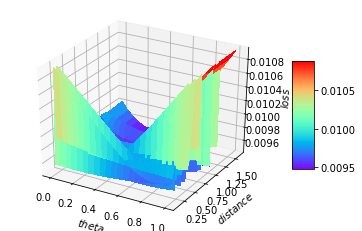

In [59]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$theta$')
ax.set_ylabel('$distance$')
ax.set_zlabel('$loss$')
# Customize the z axis.
# ax.set_xlim(0.051, 0.054)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.view_init(45, 45)
# ax.view_init(0, 0)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('fig1.png')
plt.show()